# 1.Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# 2.Load the Dataset

In [2]:
csv_file = 'market_basket.csv'
df_binary = pd.read_csv(csv_file)

print("Dataset shape:", df_binary.shape)
df_binary.head(10)

Dataset shape: (790, 11)


,TransactionID,Milk,Bread,Butter,Eggs,Cheese,Chicken,Pasta,Tomato,Rice,Juice
0,1,1,0,0,0,1,0,1,1,1,0
1,2,0,1,0,0,0,0,0,0,1,1
2,3,1,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,1,0,1,0,1
4,5,0,1,0,0,0,1,1,0,0,0
5,6,0,0,0,1,1,0,0,1,0,0
6,7,1,0,0,1,1,0,1,0,0,0
7,8,1,1,1,0,0,0,0,0,0,1
8,9,0,0,0,1,0,0,1,1,0,1
9,10,1,0,0,0,1,0,0,0,1,1


# 3.Convert to Transaction Format and One-Hot Encoding

In [3]:
transactions = []
for i in range(len(df_binary)):
    transaction = [item for item in df_binary.columns[1:] if df_binary.iloc[i][item] == 1]
    transactions.append(transaction)

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

print("\nEncoded dataset shape:", df_onehot.shape)
df_onehot.head()


Encoded dataset shape: (790, 10)


,Bread,Butter,Cheese,Chicken,Eggs,Juice,Milk,Pasta,Rice,Tomato
0,False,False,True,False,False,False,True,True,True,True
1,True,False,False,False,False,True,False,False,True,False
2,False,False,False,False,False,False,True,False,False,False
3,False,False,False,True,False,True,True,False,False,True
4,True,False,False,True,False,False,False,True,False,False


# 4. Run Apriori Algorithm with Timing

In [4]:
min_support = 0.01

start_time = time.time()
frequent_itemsets = apriori(df_onehot, min_support=min_support, use_colnames=True)
apriori_time = time.time() - start_time

frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print(f"Apriori Execution Time: {apriori_time:.4f} seconds")
print(f"Number of Frequent Itemsets Found: {len(frequent_itemsets)}")
print(f"Min Support Threshold Used: {min_support}")
print(f"Max Support Observed: {frequent_itemsets['support'].max():.4f}")

# Top 10 frequent itemsets
frequent_itemsets.sort_values('support', ascending=False).head(10)

Apriori Execution Time: 0.0081 seconds
Number of Frequent Itemsets Found: 180
Min Support Threshold Used: 0.01
Max Support Observed: 0.3810


,support,itemsets,length
5,0.381013,(Juice),1
6,0.346835,(Milk),1
7,0.331646,(Pasta),1
9,0.325316,(Tomato),1
0,0.306329,(Bread),1
8,0.284810,(Rice),1
3,0.278481,(Chicken),1
2,0.275949,(Cheese),1
1,0.274684,(Butter),1
4,0.256962,(Eggs),1


# 5. Generate Association Rules

In [5]:
start_time = time.time()
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)
rules_time = time.time() - start_time

rules = rules.sort_values('lift', ascending=False)

print(f"Association Rules Generation Time: {rules_time:.4f} seconds")
print(f"Total Association Rules Generated: {len(rules)}")

# Top 10 strongest rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)

Association Rules Generation Time: 0.0116 seconds
Total Association Rules Generated: 234


,antecedents,consequents,support,confidence,lift
71,(Bread),"(Juice, Rice)",0.075949,0.247934,2.331759
66,"(Juice, Rice)",(Bread),0.075949,0.714286,2.331759
143,(Eggs),"(Cheese, Milk)",0.067089,0.261084,2.266551
138,"(Cheese, Milk)",(Eggs),0.067089,0.582418,2.266551
141,(Cheese),"(Milk, Eggs)",0.067089,0.243119,2.207635
140,"(Milk, Eggs)",(Cheese),0.067089,0.609195,2.207635
213,(Bread),"(Juice, Rice, Cheese)",0.010127,0.033058,2.176309
204,"(Juice, Rice, Cheese)",(Bread),0.010127,0.666667,2.176309
101,(Chicken),"(Butter, Pasta)",0.068354,0.245455,2.154545
96,"(Butter, Pasta)",(Chicken),0.068354,0.600000,2.154545


# 6. Visualizations

C:\Users\HP\AppData\Local\Temp\ipykernel_10944\20104132.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=item_counts.values, y=item_counts.index, palette='viridis')


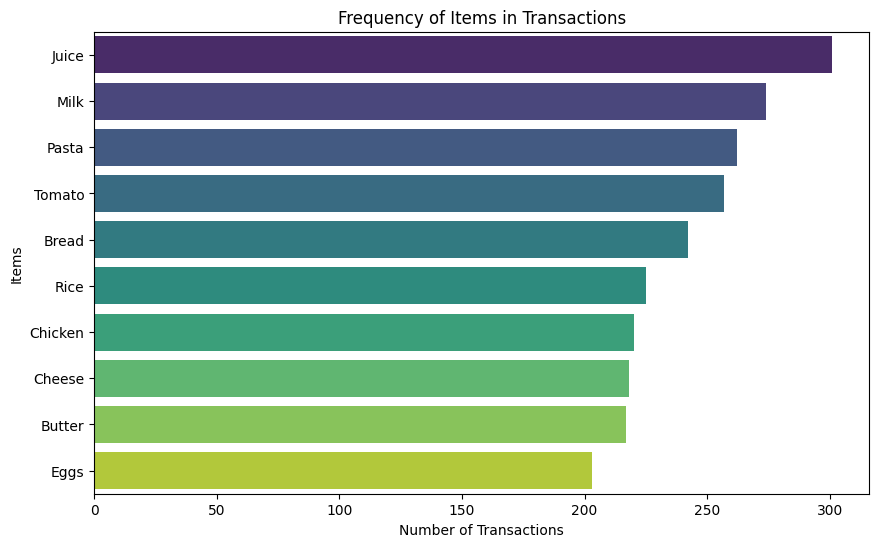

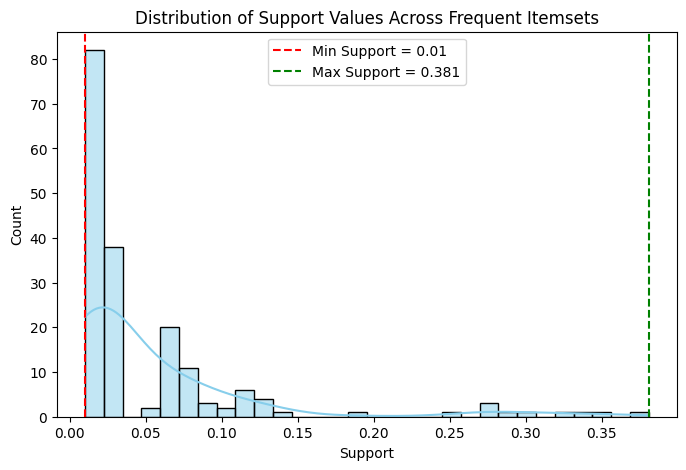

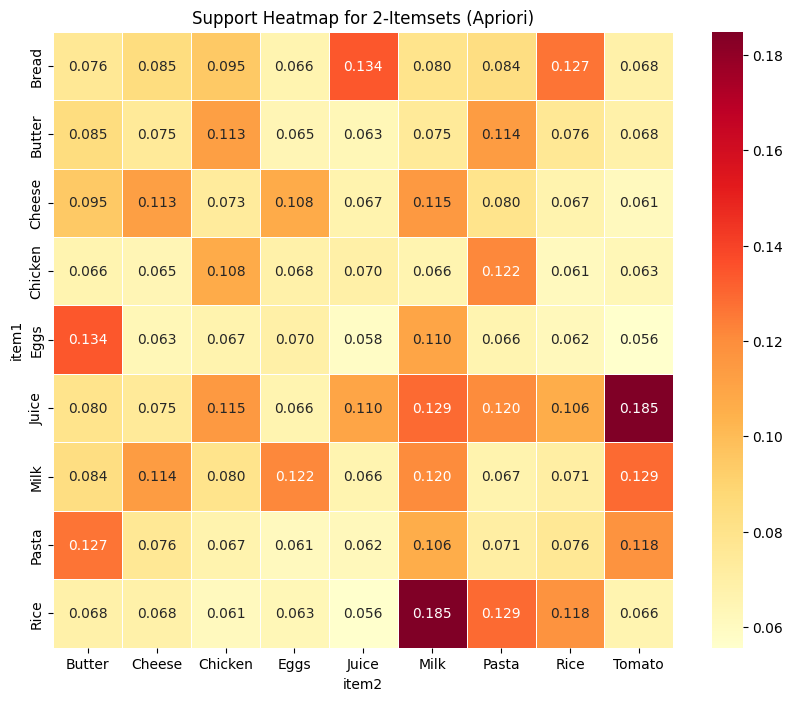

In [6]:
# Item Frequency Bar Plot
item_counts = df_onehot.sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=item_counts.values, y=item_counts.index, palette='viridis')
plt.title('Frequency of Items in Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Items')
plt.show()

# Support Distribution Histogram
plt.figure(figsize=(8, 5))
sns.histplot(frequent_itemsets['support'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Support Values Across Frequent Itemsets')
plt.xlabel('Support')
plt.ylabel('Count')
plt.axvline(min_support, color='red', linestyle='--', label=f'Min Support = {min_support}')
plt.axvline(frequent_itemsets['support'].max(), color='green', linestyle='--', label=f'Max Support = {frequent_itemsets["support"].max():.3f}')
plt.legend()
plt.show()

# Support Heatmap for 2-Itemsets
pairs = frequent_itemsets[frequent_itemsets['length'] == 2].copy()

if len(pairs) > 0:
    pairs['item1'] = pairs['itemsets'].apply(lambda x: sorted(x)[0])
    pairs['item2'] = pairs['itemsets'].apply(lambda x: sorted(x)[1])

    heatmap_data = pairs.pivot(index='item1', columns='item2', values='support').fillna(0)
    
    # Make symmetric
    for i in range(len(heatmap_data)):
        for j in range(i+1, len(heatmap_data)):
            val = heatmap_data.iloc[i, j]
            if val > 0:
                heatmap_data.iloc[j, i] = val

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd', linewidths=.5)
    plt.title('Support Heatmap for 2-Itemsets (Apriori)')
    plt.show()
else:
    print("No 2-itemsets found with current min_support.")

# 7. Evaluation

In [8]:
print("\nModel Evaluation:\n")
print(rules[['support', 'confidence', 'lift']].describe().to_string(float_format='{:.6f}'.format))

if len(rules) > 0:
    best_rule = rules.iloc[0]
    ant = ', '.join(list(best_rule['antecedents']))
    con = ', '.join(list(best_rule['consequents']))
    print(f"\nStrongest Rule: {{ {ant} }} → {{ {con} }}")
    print(f"Lift: {best_rule['lift']:.3f} | Confidence: {best_rule['confidence']:.3f} | Support: {best_rule['support']:.3f}")
else:
    print("\nNo significant association rules found with lift ≥ 1.1.")


Model Evaluation:

         support  confidence       lift
count 234.000000  234.000000 234.000000
mean    0.036633    0.251343   1.373922
std     0.034707    0.167552   0.305299
min     0.010127    0.030534   1.100098
25%     0.017722    0.087156   1.164977
50%     0.024051    0.277696   1.274843
75%     0.031646    0.364948   1.433107
max     0.184810    0.714286   2.331759

Strongest Rule: { Bread } → { Juice, Rice }
Lift: 2.332 | Confidence: 0.248 | Support: 0.076
